# Target Shuffling Implementation

A novel implementation of methodologies described in the following paper:
<br>
###### Evaluate the Vailidity of Your Discovery with Target Shuffling (John Elder)
###### https://www.elderresearch.com/wpcontent/uploads/2020/10/Whitepaper_Evaluate_the_Validity_of_Your_Discovery_with_Target_Shuffling.pdf
<br>
Briefly, the following steps will be performed:
<br>
<br>
1) Build a model and record that model's performance metric and variable coefficients (if applicable)
<br>
2) "Shuffle" the target variable, thereby breaking any relationships between explanatory and target variables
<br>
3) Build a model on the "broken" data and record the broken model's performance metric and variable coefficients
<br>
4) Repeat steps 2 and 3 many times
<br>
5) Compare the original model's performance metric and coefficient values against the distribution of the broken model performance metrics and coefficient values

# Imports

In [162]:
import pandas as pd
import numpy as np
from dfply import *
from IPython.display import clear_output
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
#import xgboost as xgb
import random
from scipy.stats import percentileofscore as POS

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last_expr"

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

# Read data

In [188]:
cc = pd.read_csv("/Users/mfairb/Documents/ML Projects/Project - Anamoly Detection/creditcard.csv")

cc = cc >> \
     drop('Time') >> \
     select('Class', 'Amount', everything())

cc = cc.iloc[:,0:7]

X = cc >> drop('Class', 'V3')
y = cc >> select('Class')

X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2, random_state = 273)

# Target Shuffling

In [190]:
def target_shuffle(X_train, X_valid, y_train, y_valid, target, n):
    
    """
    ○ X_train: df of training set predictors
    ○ X_valid: df of validation set predictos
    ○ y_train: df of training set labels
    ○ y_valid: df of validation set labels
    ○ target: name of target variable (string)
    ○ n: number of shuffling iterations
    """
        
    # Create empty data frame
    coefs = pd.DataFrame()
    #acc = list()
    
    # Create n models and save coefficients
    for i in range(1, (n+1)):
        
            # Set seed
            random.seed(i)
            
            # Create shuffled version of y
            y_shuffled = y_train.sample(len(y_train), replace = False)
    
            # Create shuffled logistic, get predictions, and score
            temp_log = LogisticRegression().fit(X_train, y_shuffled.values.ravel())
            temp_preds = temp_log.predict_proba(X_valid)[:,1]
            temp_score = roc_auc_score(y_valid, temp_preds)

            # Get coefficients from temp_log
            coefs = coefs.append( list([np.append(temp_score, temp_log.coef_[0])]) )
            
            # Progress
            if i % 20 == 0:
                print(str(i) + " rounds completed")
    
    # Add column names to shuffle
    X_cols = list(X_train.columns)
    X_cols.insert(0, "AUC")
    coefs.columns = X_cols
    
    return(coefs)

###### Create model and then perform target shuffling

In [ ]:
# Logistic regression
log = LogisticRegression().fit(X_train, y_train.values.ravel())
log_preds = log.predict_proba(X_test)[:,1]
log_auc = roc_auc_score(y_test, log_preds)


coefs = target_shuffle(X_train = X_train, 
                            y_train = y_train, 
                            X_valid = X_test, 
                            y_valid = y_test, 
                            target = 'Class', 
                            n = 300)

###### Plot distributions

In [219]:
def plot_shuffles(coefs,
                  plot=['acc', 'coefs']):
    
    ###---Plot individual coefficients---###
    if 'coefs' in plot:
        # Include for plotting in for loops
        from IPython.core.interactiveshell import InteractiveShell
        InteractiveShell.ast_node_interactivity = "last_expr"
        
        log_coef_2 = list( [np.append(log_auc, log.coef_[0])] )[0]
        
        for i in range(0, len(log_coef_2)):
            
            # Calculate percentile of original model values
            perc = POS(coefs.iloc[:,i], log_coef_2[i])
            sig = round(100 - perc, 2) # Get probability of finding due to chance
            min_metric=min(perc, sig)
            
            # Plot
            plt.hist(coefs.iloc[:,i], density=True, bins=30)  # `density=False` would make counts
            plt.axvline(x = log_coef_2[i], c='red')
            plt.suptitle(coefs.columns[i], fontsize=13)
            plt.title(f'~{min_metric}% chance original results was due to chance', fontsize=10)
            plt.ylabel('Probability')
            plt.xlabel('Data')
            plt.show();

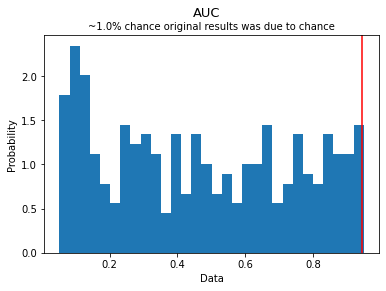

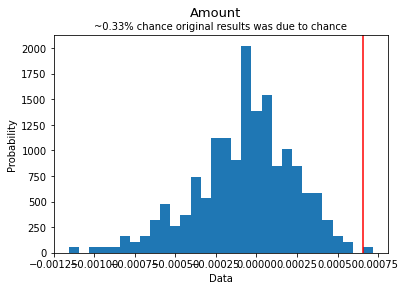

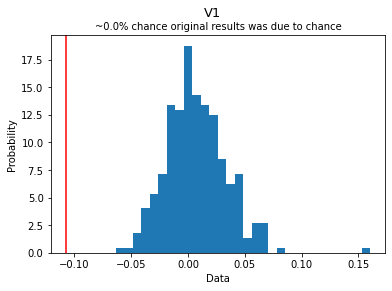

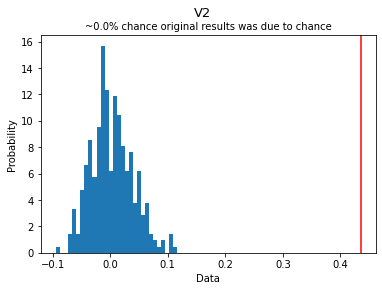

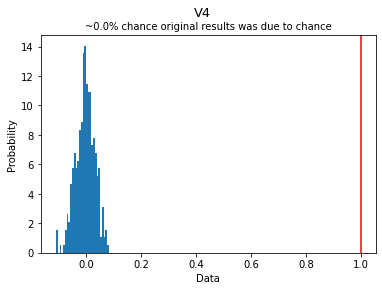

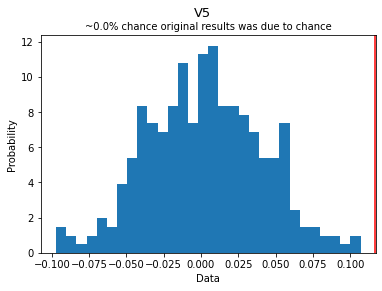

In [220]:
# Plot performance and coefficient distributions
plot_shuffles(coefs)